## Multi-Class Prediction of Obesity Risk 肥胖風險的多類別預測
- 利用各種因素來預測與心血管疾病相關的個人肥胖風險。
- 這些數據包括墨西哥、秘魯和哥倫比亞國家人口肥胖程度的估計，年齡在14 歲至61 歲之間，飲食習慣和身體狀況各不相同，數據是透過網路平台收集的，並進行了一項調查，其中匿名使用者回答了每個問題問題，然後對資訊進行處理，獲得 17 個屬性和 2111 條記錄。

### 預測
- 肥胖類型 (target : NObeyesdad)

### 特徵定義
- id &rArr; ID
- Gender &rArr; 頻繁食用高熱量食物
- Age &rArr; 頻繁食用高熱量食物
- Height &rArr; 頻繁食用高熱量食物
- Weight &rArr; 頻繁食用高熱量食物
- family_history_with_overweight &rArr; 家族是否有肥胖史
- FAVC &rArr; 頻繁食用高熱量食物
- FCVC &rArr; 食用蔬菜頻率
- NCP &rArr; 主餐次數
- CAEC &rArr; 兩餐之間食物消耗量
- CH20 &rArr; 每日飲水量
- CALC &rArr; 酒精消耗量
- SCC &rArr; 卡路里消耗監測
- FAF &rArr; 體力活動頻率
- TUE &rArr; 使用科技設備的時間
- MTRANS &rArr; 使用的交通工具
- NObesity 值為 BMI 類別：
    - Insufficient_Weight 體重不足小於18.5
    - Normal_Weight : 正常18.5至24.9
    - Overweight : 超重25.0至29.9
    - Obesity I : 肥胖I 30.0至34.9
    - Obesity II : 肥胖II 35.0至39.9
    - Obesity III : 肥胖III 高於40


In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('./data/Multi-Class Prediction of Obesity Risk/train.csv')
df_train.head(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
df_test = pd.read_csv('./data/Multi-Class Prediction of Obesity Risk/test.csv')
df_test.head(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [6]:
df_train.drop(columns=["id"]).describe().style.background_gradient()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

<Axes: xlabel='count', ylabel='NObeyesdad'>

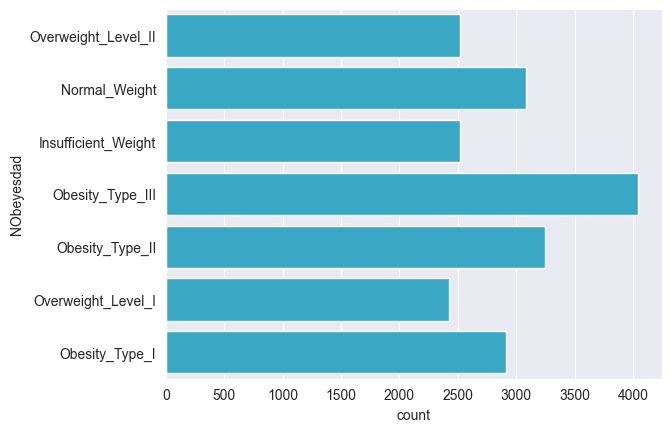

In [18]:
# 觀察目標資料分布
sns.countplot(df_train["NObeyesdad"], palette = ["#23b6db"])
